In [1]:
from jax import numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel, Stratification
from summer2.parameters import Parameter, DerivedOutput

In [2]:
def build_demog_model(
    config: dict,
    vacc_coverage: float,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "Susceptible", 
        "Pre-infectious", 
        "Infectious", 
        "Immune"
    )
    model = CompartmentalModel(
        times=(
            config["start_time"] * 365.,
            config["end_time"] * 365.,
        ),
        compartments=compartments,
        infectious_compartments=["Infectious"],
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["total_population"] - config["infectious_seed"], 
            "Infectious": config["infectious_seed"],
        }
    )
    
    # Transitions
    infectious_period = Parameter("infectious_period")
    life_expectancy = Parameter("life_expectancy")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("r0") / infectious_period,
        source="Susceptible", 
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("latent_period"),
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / infectious_period,
        source="Infectious", 
        dest="Immune",
    )
    model.add_universal_death_flows(
        "universal_death",
        death_rate=1. / life_expectancy / 365.,
    )
    model.add_crude_birth_flow(
        "births",
        1. / life_expectancy / 365.,
        "Susceptible",
    )
    
    model.request_output_for_compartments(
        "total_population",
        compartments,
    )
    
    model.request_output_for_flow(
        name="incidence",
        flow_name="progression",
    )
    
    model.request_function_output(
        name="incidence_rate",
        func=DerivedOutput("incidence") / DerivedOutput("total_population") * 1e5
    )

    # Vaccination stratification
    vacc_strat = Stratification(
        "vaccination",
        ["vaccinated", "unvaccinated"],
        ["Susceptible"],
    )
    vacc_strat.set_population_split(
        {
            "vaccinated": 0.,
            "unvaccinated": 1.,
        }
    )
    vacc_strat.set_flow_adjustments(
        flow_name="infection",
        adjustments={
            "vaccinated": 0.,
            "unvaccinated": 1.,
        },
    )
    
    def step_up(time, values):
        return jnp.where(time > 0., vacc_coverage, 0.)
    
    def step_down(time, values):
        return jnp.where(time > 0., 1. - vacc_coverage, 1.)
    
    vacc_strat.set_flow_adjustments(
        flow_name="births",
        adjustments={
            "vaccinated": step_up,
            "unvaccinated": step_down,
        },
    )
    model.stratify_with(vacc_strat)    

    return model

In [9]:
model_config = {
    "start_time": -72.,
    "end_time": 30.,
    "total_population": 1e5,
    "infectious_seed": 1.,
}

parameters = {
    "r0": 13.,
    "latent_period": 8.,
    "infectious_period": 7.,
    "life_expectancy": 70.,
}

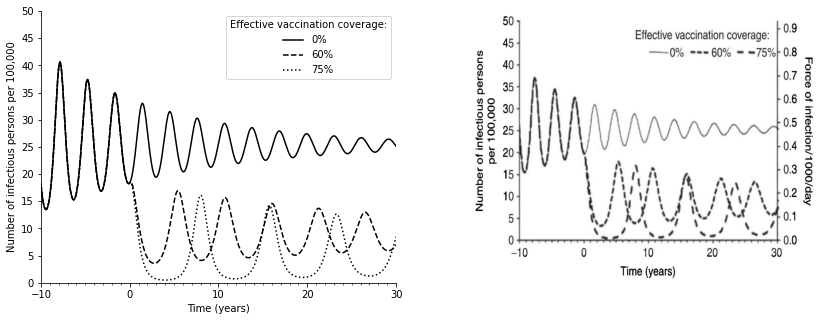

In [10]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
line_styles = ("-", "--", ":")
coverage_values = (0., 0.6, 0.75)
outputs = pd.DataFrame(columns=coverage_values)

for i_cov, coverage in enumerate(coverage_values):

    # Vaccination coverage should be a parameter to get model build out of loop, but haven't been able to
    vacc_model = build_demog_model(
        config=model_config,
        vacc_coverage=coverage,
    )
    vacc_model.run(parameters=parameters, solver="euler")
    outputs[coverage] = vacc_model.get_outputs_df()["Infectious"]
    
    left_ax.plot(
        outputs.index / 365.,
        outputs[coverage],
        color="k",
        linestyle=line_styles[i_cov],
        label=f"{int(coverage * 100)}%",
    )
    
left_ax.legend(title="Effective vaccination coverage:")
left_ax.set_xlim(-10., model_config["end_time"])
left_ax.set_xticks(range(-10, 40, 10))
left_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
left_ax.set_xlabel("Time (years)")
left_ax.set_ylim(0., 50.)
left_ax.set_yticks(range(0, 55, 5))
left_ax.set_ylabel("Number of infectious persons per 100,000")
left_ax.spines.top.set_visible(False)
# Although force of infection is mentioned in the textbook version, this isn't presented
left_ax.spines.right.set_visible(False)

image = plt.imread("./figures/fig_5_13.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");